# BCycle all-data Models 

This notebook uses the cleaned data for all trips from the opening of BCycle in 2013 through to the end of 2016. The data provide from BCycle is split into two normalized tables:

## `all_trips_clean.csv`

This is the time-varying trips table, and has the following columns:

* `datetime`: Time the trip began in YYYY-MM-DD HH:MM:SS format. The resolution is 1 minute, i.e. SS is always 00.
* `membership`: Categorical column with memebrship type.
* `bike_id`: Integer ID of the bike used for a trip
* `checkout_id`: ID of the station where the bike was checked out (links to stations table).
* `checkin_id`: ID of the station where the bike was checked in (links to stations table).
* `duration`: The length of the trip in minutes


## `all_stations_clean.csv`

This contains the static station information for all 

* `address`: Station address
* `lat`: Station latitude
* `lon`: Station longitude
* `name`: Station Name
* `station_id`: Station unique identifier (ID), used to link to trips table



## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

# Load station and trip data

The `notebooks/bcycle_all_data_eda` notebook cleans up the raw CSV file from BCycle, and splits it into a stations and trips dataframe. Because of this, the clean CSV files read in below shouldn't need too much processing. The `bcycle_lib` library contains the functions to load and clean the data.

In [2]:
from bcycle_lib.all_utils import load_bcycle_data

print('Loading stations and trips....', end='')
stations_df, trips_df = load_bcycle_data('../input', 'all_stations_clean.csv', 'all_trips_clean.csv', verbose=False)
print('done!')
print('Bike trips loaded from {} to {}'.format(trips_df.index[0], trips_df.index[-1]))

print('\nStations DF info:')
stations_df.info()
print('\nTrips DF info:')
trips_df.info()

Loading stations and trips....done!
Bike trips loaded from 2013-12-21 09:09:00 to 2016-12-31 23:43:02

Stations DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
address       67 non-null object
lat           67 non-null float32
lon           67 non-null float32
name          67 non-null object
station_id    67 non-null uint8
dtypes: float32(2), object(2), uint8(1)
memory usage: 1.7+ KB

Trips DF info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548158 entries, 2013-12-21 09:09:00 to 2016-12-31 23:43:02
Data columns (total 5 columns):
membership     548158 non-null category
bike_id        548158 non-null uint16
checkout_id    548158 non-null uint8
checkin_id     548158 non-null uint8
duration       548158 non-null uint16
dtypes: category(1), uint16(2), uint8(2)
memory usage: 7.8 MB


# Load weather data

When we train the models, we'll use weather data to add some extra information for the model to learn from. With a little bit of investigation we can form our own URLs to get data ranges. Here's a typical URL


```
March 8th to September 21st:
https://www.wunderground.com/history/airport/KATT/2013/3/8/CustomHistory.html?dayend=21&monthend=9&yearend=2013&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```
From this example we can piece together where each of the day, month, and year fields come for the start and end time ranges. For example 

```
MM/DD/YYYY to MM2/DD2/YYYY

https://www.wunderground.com/history/airport/KATT/<YYYY>/<MM>/<DD>/CustomHistory.html?dayend=<DD2>&monthend=<MM2>&yearend=<YYYY>&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```

Let's make a function that takes two dates, and returns a pandas dataframe of the weather between these. The API only returns up to a year at-a-time, so we'll make multiple calls if there are multiple years.

In [3]:
# import requests
# import io

# def weather_url_from_dates(start_date, end_date):
#     '''Creates a URL string to fetch weather data between dates
#     INPUT: start_date - start date for weather
#            end_date - end date for weather
#     RETURNS: string of the URL 
#     '''
#     assert start_date.year == end_date.year, 'Weather requests have to use same year'
    
#     url = 'https://www.wunderground.com/history/airport/KATT/'
#     url += str(start_date.year) + '/' 
#     url += str(start_date.month) + '/'
#     url += str(start_date.day) + '/'
#     url += 'CustomHistory.html?dayend=' + str(end_date.day)
#     url += '&monthend=' + str(end_date.month)
#     url += '&yearend=' + str(end_date.year)
#     url += '&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1'
    
#     return url

# def weather_from_df_dates(df, verbose=False):
#     '''Returns a dictionary of weather dataframes, one per year
#     INPUT: Dataframe with date index
#     RETURNS : Dataframe of corresponding weather information
#     '''
#     yearly_weather = list()
#     unique_years = set(trips_df.index.year)
#     sorted_years = sorted(unique_years, key=int)
    
#     for year in sorted_years:
#         year_df = trips_df[str(year)]
#         start_date = year_df.index[0]
#         end_date = year_df.index[-1]
#         year_url = weather_url_from_dates(start_date, end_date)
#         if verbose:
#             print('Year {}: start date {}, end date {}'.format(year, start_date, end_date))
# #             print('URL: {}'.format(year_url))

#         if verbose: print('Fetching CSV data ... ', end='')
#         req = requests.get(year_url).content
#         req_df = pd.read_csv(io.StringIO(req.decode('utf-8')))
#         yearly_weather.append(req_df)
#         if verbose: print('done')
            
#     combined_df = pd.concat(yearly_weather)
#     return combined_df

# weather_df = weather_from_df_dates(trips_df, verbose=True)
# print('weather_df shape: {}'.format(weather_df.shape))

# Cleaning weather data

There are some missing values in the weather data. For numeric ones like the Dew Point and Humidity, we'll forward-fill the NA values. For `Events`, a missing value means there wasn't an event on that day, so we don't want to forward fill and add events that didn't happen on that day.

In [4]:
# from bcycle_lib.all_utils import clean_weather
# # Let's check the data for missing values, and forward-fill
# # print('Initial Weather missing value counts:')
# # print(weather_df.isnull().sum(axis=0))

# for col in weather_df.columns:
#     if 'Events' not in col:
#         weather_df[col] = weather_df[col].fillna(method='pad')

# print('\nAfter forward-filling NA values (apart from Events):')
# print(weather_df.isnull().sum(axis=0))

### Save weather out to CSV

For repeatability we can save out the weather data we just downloaded to a CSV file. First of all we need to clean up the columns, and then we can write it out.

In [5]:
# from bcycle_lib.all_utils import clean_weather

# weather_df = clean_weather(weather_df)
# weather_df.to_csv('../input/all_weather.csv')

In [6]:
from bcycle_lib.all_utils import clean_weather

weather_df = pd.read_csv('../input/all_weather.csv')
weather_df = weather_df.set_index('date')
weather_df.head()

,max_temp,min_temp,max_humidity,min_humidity,max_pressure,min_pressure,max_wind,min_wind,max_gust,precipitation,cloud_pct,thunderstorm,snow,rain,fog
date,,,,,,,,,,,,,,,
2013-12-21,74,45,93,57,29.86,29.59,20,4,31,0.46,75.0,1,0,1,0
2013-12-22,56,39,93,43,30.41,29.87,16,6,25,0.00,25.0,0,0,0,0
2013-12-23,58,32,76,27,30.56,30.41,8,3,12,0.00,0.0,0,0,0,0
2013-12-24,61,31,89,22,30.56,30.30,12,4,20,0.00,0.0,0,0,0,0
2013-12-25,58,41,86,56,30.41,30.27,10,2,16,0.01,87.5,0,0,0,0


# Time-based linear model

Let's kick off by creating a linear model based on time features.

In [7]:
from bcycle_lib.all_utils import add_time_features

TRAIN_START = '2014-01-01'
TRAIN_END = '2016-05-31'
VAL_START = '2016-06-01'
VAL_END = '2016-12-31'

hourly_trips_df = trips_df.resample('1H').size().to_frame(name='count')
hourly_trips_df = add_time_features(hourly_trips_df)
train_df = hourly_trips_df[TRAIN_START:TRAIN_END].copy()
val_df = hourly_trips_df[VAL_START:VAL_END].copy()

n_train = train_df.shape[0]
n_val = val_df.shape[0]
n_total = n_train + n_val
n_train_pct = (n_train / n_total) * 100.0
n_val_pct = (n_val / n_total) * 100.0

print('\nTraining data first and last row:\n{}\n{}'.format(train_df.index[0], train_df.index[-1]))
print('\nValidation data first and last row:\n{}\n{}\n'.format(val_df.index[0], val_df.index[-1]))

print('Train data shape: {}, {:.2f}% of rows'.format(train_df.shape, n_train_pct))
print('Validation data shape: {}, {:.2f}% of rows'.format(val_df.shape, n_val_pct))

train_df.head()


Training data first and last row:
2014-01-01 00:00:00
2016-05-31 23:00:00

Validation data first and last row:
2016-06-01 00:00:00
2016-12-31 23:00:00

Train data shape: (21168, 2), 80.47% of rows
Validation data shape: (5136, 2), 19.53% of rows


,count,day-hour
datetime,,
2014-01-01 00:00:00,4,2-0
2014-01-01 01:00:00,0,2-1
2014-01-01 02:00:00,5,2-2
2014-01-01 03:00:00,3,2-3
2014-01-01 04:00:00,0,2-4


# Visualizing hourly rentals

Now we can visualize the training and validation rental data separately. To keep the graphs clear, we'll resample according to the length of data we're dealing with. The training data is from 2014, 2015, and the first half of 2016. The validation data is from the second half of 2016.

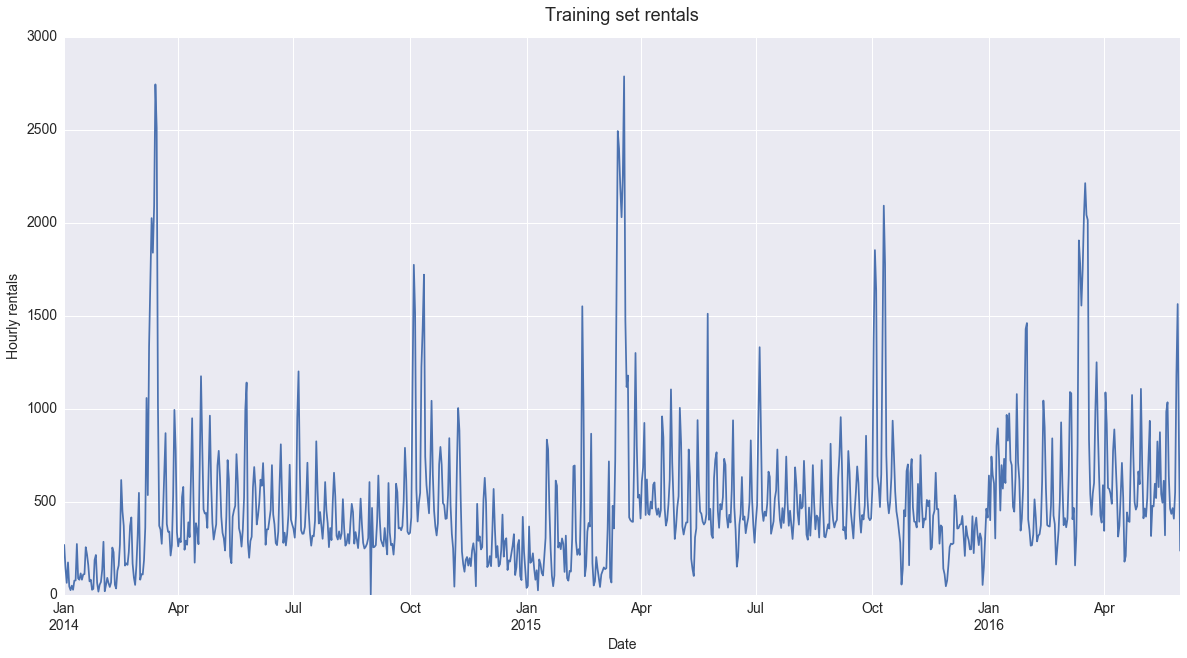

In [8]:
from bcycle_lib.all_utils import plot_lines

plot_df = train_df.resample('1D').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Training set rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

The graph shows a single approximately week-long spike in March (during SXSW) of 2750 - 2250 trips. There are also  two sharp peaks a week apart in October (during ACL) of 1750-2000 daily trips. 

After these peaks, there are other days with between 1000 and 1500 trips. There's one in mid-Feb, one towards the end of April, one at the end of May, and another at the start of July. These most likely correspond to national holidays. 

For these special cases, we'll need to add in extra dummy variables to help models work out why the amount of trips suddenly peaks.

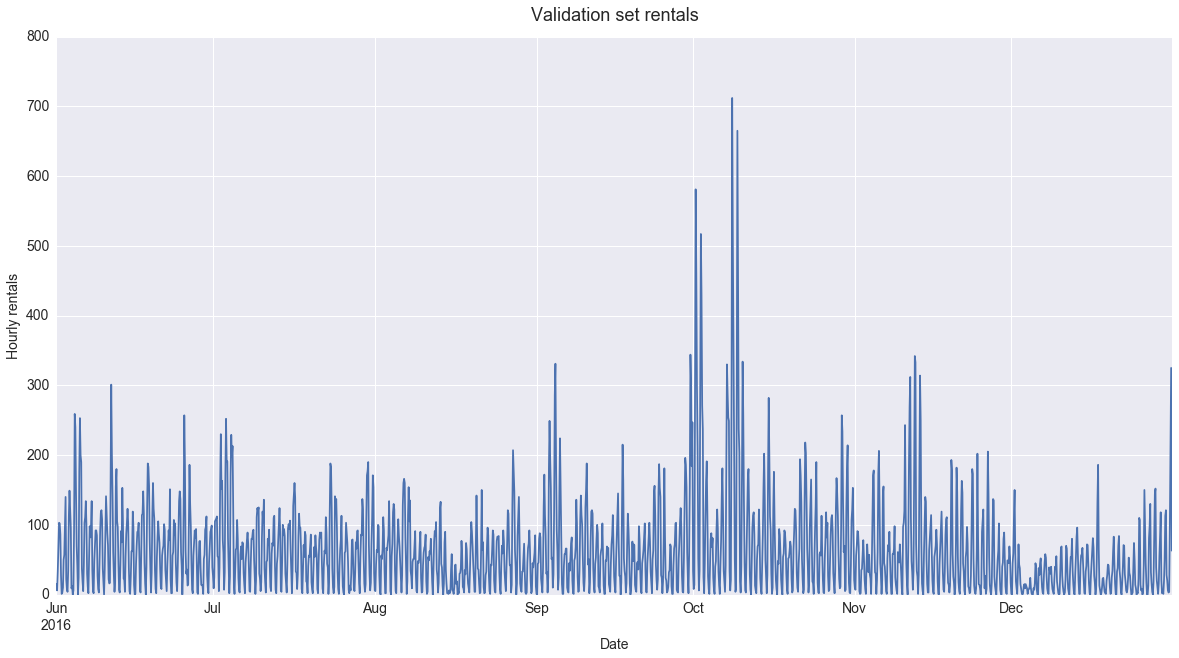

In [9]:
# Let's plot the validation set
plot_df = val_df.resample('3H').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Validation set rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

The 6-month period of the validation data allows us to see multiple levels of periodicity in the data. The shortest is the daily period. The weekly period is also visible, with most weeks ending in higher levels of trips on Friday, Saturday, and Sunday. 

There are also some special events which are one-off. The spike at the start of September is probably due to the Labor Day holiday, and the one at the end of November is likely Thanksgiving. The two largest peaks are the first two weekends in October, and these correspond to ACL.

# Distributions in training and validation datasets

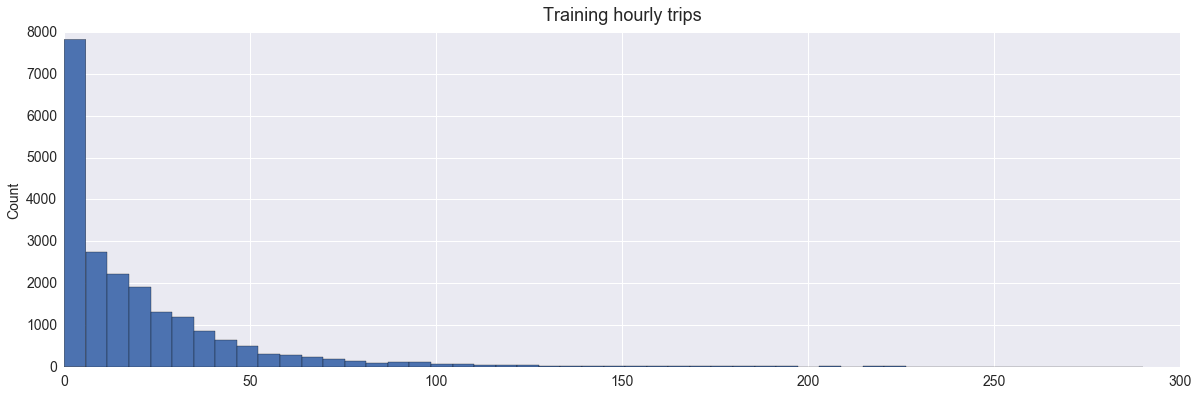

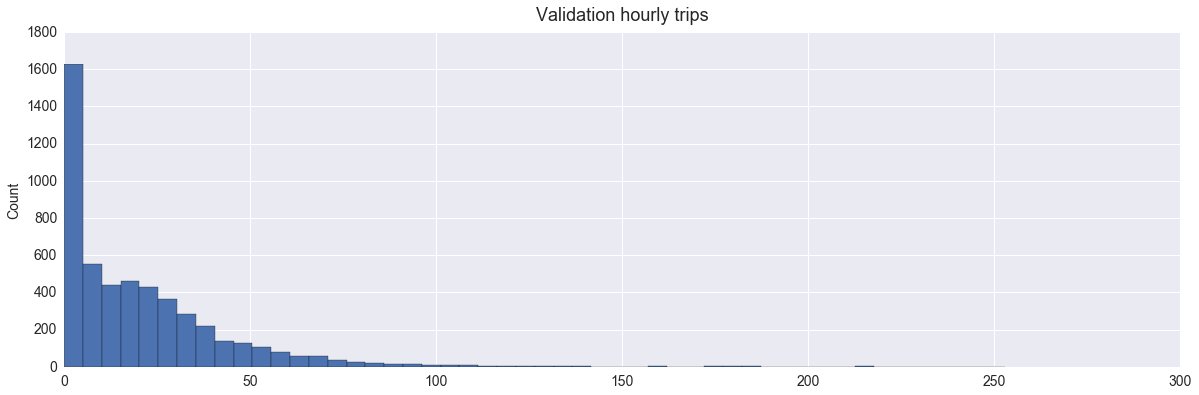

In [10]:
from bcycle_lib.all_utils import plot_hist
SIZE=(20,6)
plot_hist(train_df['count'], bins=50, size=SIZE, title='Training hourly trips', xlabel='', ylabel='Count')
plot_hist(val_df['count'], bins=50, size=SIZE, title='Validation hourly trips', xlabel='', ylabel='Count')



# Baseline linear model

Now we have inspected some of the data, let's create a baseline linear model using time features.

In [11]:
# First create a daily rentals dataframe, split it into training and validation
from bcycle_lib.all_utils import add_time_features

train_df = add_time_features(train_df)
val_df = add_time_features(val_df)

print('Training data shape: {}'.format(train_df.shape))
print('Validation data shape: {}'.format(val_df.shape))

Training data shape: (21168, 2)
Validation data shape: (5136, 2)


In [12]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df[['day-hour', 'count']], 
                                           target_col='count', 
                                           ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df[['day-hour', 'count']], 
                                     target_col='count', 
                                     ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (21168, 168), y_train shape: (21168,)
X_val shape: (5136, 168), y_val shape: (5136,)


Linear reg baseline RMSE - Train: 21.37, Val: 16.76


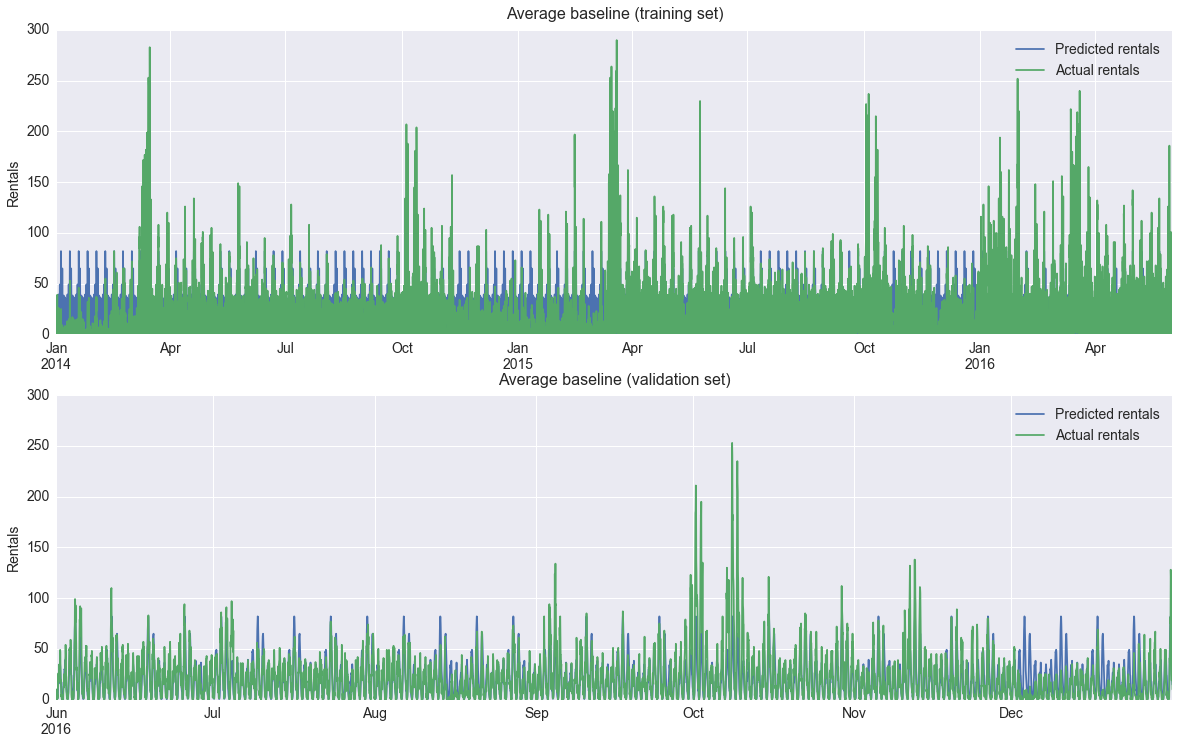

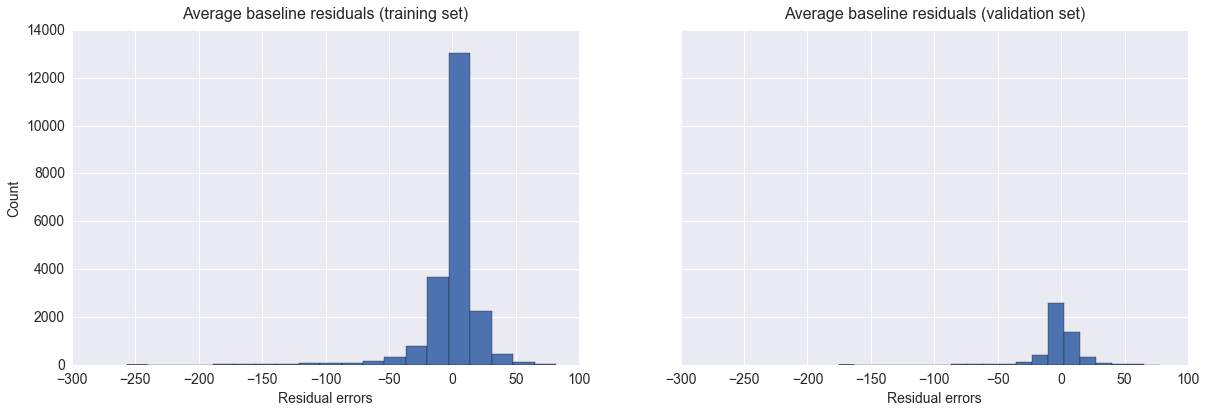

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from bcycle_lib.all_utils import df_from_results, plot_results, plot_val

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores_df = pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, index=['time_linreg'])


result_train_df, result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                 val_df.index, y_val, y_val_pred)

print('Linear reg baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))
plot_results(result_train_df, result_val_df, 'pred', 'true', title='Average baseline')



This is not a bad baseline model. Strangely, it gets a worse RMSE on the Training dataset than the validation dataset. This is probably because the data in 2014 is markedly lower than in 2015, and the validation set is somewhere in between. This implies I need to add some lagging indicators, as each hourly value is closely correlated with the ones that came before.

# Linear model with holiday and special events

As we saw when inspecting the data, there are quite a few peaks due to special events, and national holidays. Let's add in some dummy variables, so the model factors these into the result.

### Holidays

We'll create a set of indicator variables for each of the holidays, as well as the dates around them. For example if a holiday is on a Monday, we'll add the Saturday and Sunday before that day. Also on Thanksgiving (which is on a Thursday) we'll add in Fri, Sat, and Sun that week.

In [14]:
# Create a list of national holidays, with their observed dates days around them
holidays = {'hol_new_year' : ('2014-01-01', '2015-01-01', '2016-01-01'),
            'hol_mlk' : ('2014-01-18', '2014-01-19','2014-01-20',
                         '2015-01-17', '2015-01-18','2015-01-19',
                         '2016-01-16', '2016-01-17','2016-01-18'),
            'hol_presidents' : ('2014-02-15', '2014-02-16', '2014-02-17',
                                '2015-02-14', '2015-02-15', '2015-02-16',
                                '2016-02-13', '2016-02-14', '2016-02-15'),
            'hol_memorial' : ('2014-05-24', '2014-05-25', '2014-05-26',
                              '2015-05-23', '2015-05-24', '2015-05-25',
                              '2016-05-28', '2016-05-29', '2016-05-30'),
            'hol_independence' : ('2014-07-04', '2014-07-05', '2014-07-06',
                                  '2015-07-03', '2015-07-04', '2015-07-05',
                                  '2016-07-02', '2016-07-03', '2016-07-04'),
            'hol_labor' : ('2014-08-30', '2014-08-31', '2014-09-01',
                           '2015-09-05', '2015-09-06', '2015-09-07',
                           '2016-09-03', '2016-09-04', '2016-09-05'),
            'hol_columbus' : ('2014-10-11', '2014-10-12', '2014-10-13',
                              '2015-10-10', '2015-10-11', '2015-10-12',
                              '2016-10-08', '2016-10-09', '2016-10-10'),
            'hol_veterans' : ('2014-11-11', '2015-11-11', '2016-11-11'),
            'hol_thanksgiving' : ('2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
                                  '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29',
                                  '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27'),
            'hol_christmas' : ('2014-12-25', '2014-12-26', '2014-12-27', '2014-12-28',
                               '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
                               '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27')
           }


def add_date_indicator(df, col, dates):
    '''Adds a new indicator column with given dates set to 1
    INPUT: df - Dataframe
           col - New column name
           dates - Tuple of dates to set indicator to 1
    RETURNS: Dataframe with new column
    '''
    df.loc[:,col] = 0
    for date in dates:
        if date in df.index:
            df.loc[date, col] = 1
            
    df[col] = df[col].astype(np.uint8)
    return df

for key, value in holidays.items():
    train_df = add_date_indicator(train_df, key, value)
    val_df = add_date_indicator(val_df, key, value)

### Events

Now we can add in the special events that generate a huge spike in traffic in March and October. This helps the model work out it's not just a normal Saturday . Sunday.

In [15]:
# Create a list of national holidays, with their observed dates days around them
import itertools

def day_list(start_date, end_date):
    '''Creates list of dates between `start_date` and `end_date`'''
    date_range = pd.date_range(start_date, end_date)
    dates = [d.strftime('%Y-%m-%d') for d in date_range]
    return dates

sxsw2014 = day_list('2014-03-07', '2014-03-16')
sxsw2015 = day_list('2015-03-13', '2015-03-22')
sxsw2016 = day_list('2016-03-11', '2016-03-20')
sxsw = list(itertools.chain.from_iterable([sxsw2014, sxsw2015, sxsw2016]))

acl2014_wk1 = day_list('2014-10-03', '2014-10-05')
acl2014_wk2 = day_list('2014-10-10', '2014-10-12')
acl2015_wk1 = day_list('2015-10-02', '2015-10-04')
acl2015_wk2 = day_list('2015-10-09', '2015-10-11')
acl2016_wk1 = day_list('2016-09-30', '2016-10-02')
acl2016_wk2 = day_list('2016-10-07', '2016-10-09')
acl = list(itertools.chain.from_iterable([acl2014_wk1, acl2014_wk2, 
                                          acl2015_wk1, acl2015_wk2, 
                                          acl2016_wk1, acl2016_wk2]))


events = {'event_sxsw' : sxsw,
          'event_acl'  : acl
         }

for key, value in events.items():
    train_df = add_date_indicator(train_df, key, value)
    val_df = add_date_indicator(val_df, key, value)


In [16]:
# Check they were all added here 1
train_df.describe()
# train_df.head()

# train_df[train_df['event_sxsw'] == 1]

,count,hol_christmas,hol_mlk,hol_memorial,hol_independence,hol_new_year,hol_veterans,hol_labor,hol_thanksgiving,hol_columbus,hol_presidents,event_sxsw,event_acl
count,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000,21168.000000
mean,20.709609,0.009070,0.010204,0.010204,0.006803,0.003401,0.002268,0.006803,0.009070,0.006803,0.010204,0.034014,0.013605
std,28.379925,0.094807,0.100501,0.100501,0.082200,0.058223,0.047566,0.082200,0.094807,0.082200,0.100501,0.181268,0.115849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,290.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Training model with new time features (holidays and special events)

Now we've manually annotated all the days with special events and hoildays, let's see if that improves the model training results on the validation set.

In [17]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (21168, 180), y_train shape: (21168,)
X_val shape: (5136, 180), y_val shape: (5136,)


Time and Weather Feature Regression RMSE - Train: 18.18, Val: 14.60


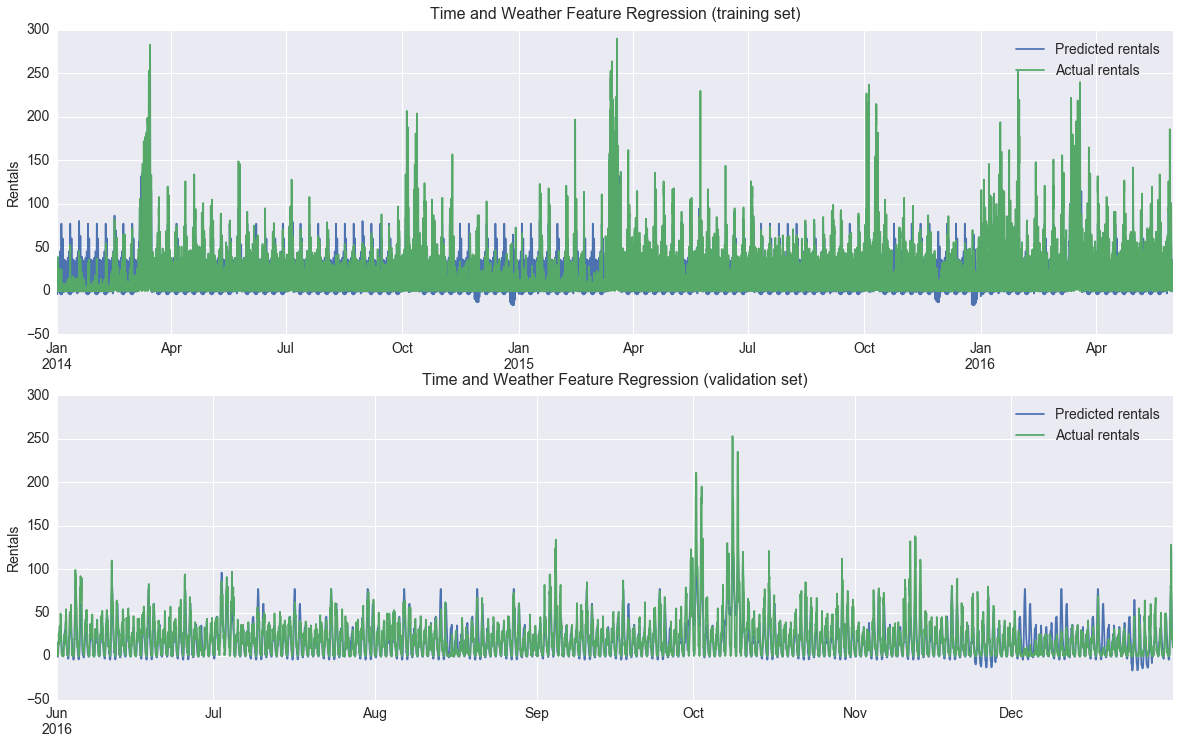

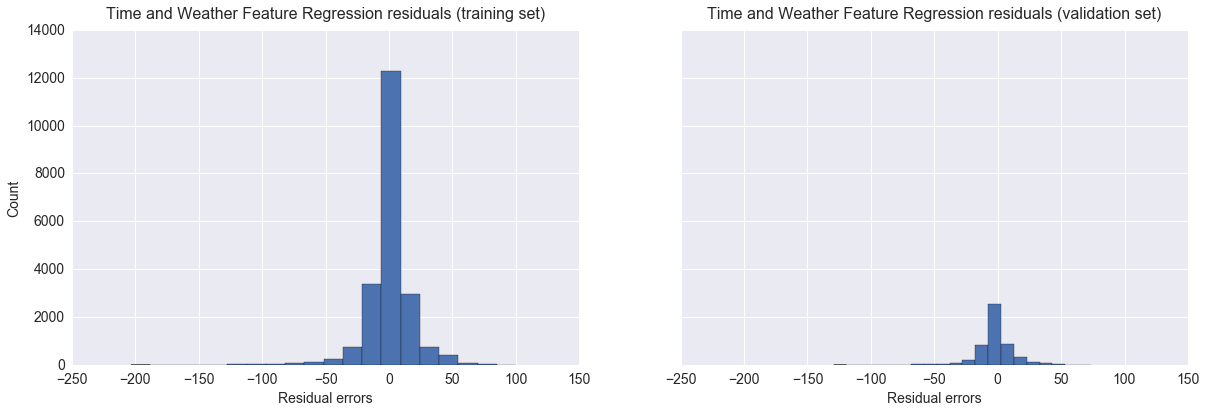

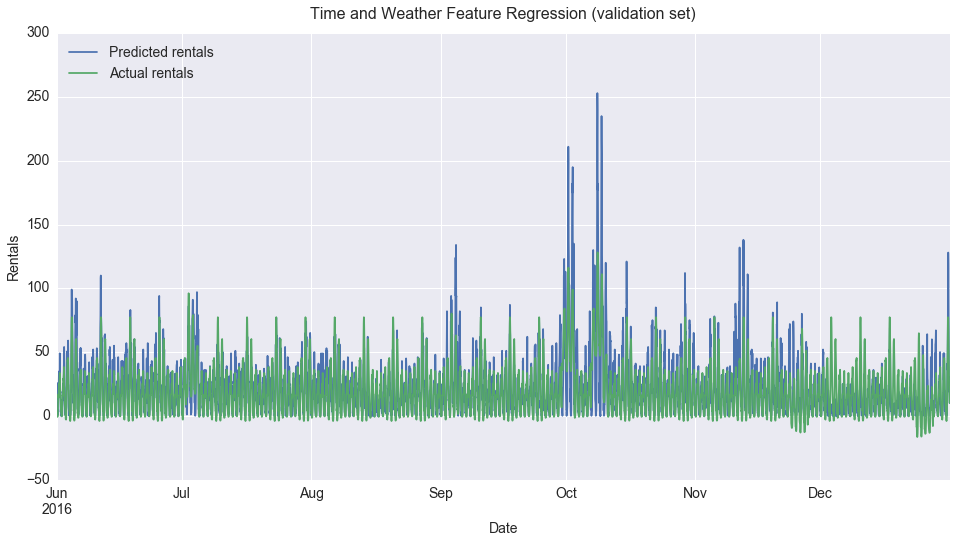

In [18]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Store the evaluation results
if 'linreg_time_events' not in scores_df.index:
    scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
                                              index=['linreg_time_events']))

print('Time and Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')

# Linear model with holidays, events, and lagged features

Now we have one-off special events and holidays added to the model to account for point increases over a day or two, we can add lagged time features to model longer-term changes in the amount of rentals. Let's 

In [19]:
def add_lag_time_features(df, col):
    """Adds time-lagged features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra lag features
    """
#     df[col + '_lag_1H'] = df[col].shift(1).fillna(method='backfill')
    df[col + '_lag_1D'] = df[col].shift(24).fillna(method='backfill')
    df[col + '_lag_1W'] = df[col].shift(24*7).fillna(method='backfill')
    return df

def add_win_time_features(df, col):
    """Adds rolling window features to improve prediction
    INPUT: df - Dataframe with date index
           col - column in dataframe used to calculate lags
    RETURNS: Dataframe with extra window features
    """
#     df[col + '_win_1H'] = df[col].rolling(window=1, win_type='blackman').mean().fillna(method='backfill')
    df[col + '_win_1D'] = df[col].rolling(window=24, win_type='blackman').mean().fillna(method='backfill')
    df[col + '_win_1W'] = df[col].rolling(window=24*7, win_type='blackman').mean().fillna(method='backfill')
    return df

def add_median_time_features(df, col):
    """Adds median bike rental values to correct for longer term changes
    """
    df[col + '_med_1D'] = df[col].shift(24).resample('1D').median()
    df[col + '_med_1D'] = df[col + '_med_1D'].fillna(method='ffill').fillna(0)
    df[col + '_med_1W'] = df[col].shift(24*7).resample('1W').median()
    df[col + '_med_1W'] = df[col + '_med_1W'].fillna(method='ffill').fillna(0)
    df[col + '_med_1M'] = df[col].shift(24*30).resample('1M').median()
    df[col + '_med_1M'] = df[col + '_med_1M'].fillna(method='ffill').fillna(0)
    return df


train_df = add_lag_time_features(train_df, 'count')
val_df   = add_lag_time_features(val_df  , 'count')

train_df = add_win_time_features(train_df, 'count')
val_df   = add_win_time_features(val_df  , 'count')

train_df = add_median_time_features(train_df, 'count')
val_df   = add_median_time_features(val_df  , 'count')

### Plotting lag and window features

Now we've added the window and lag features, let's see how they look compared with the actual values that were used to calculate them.

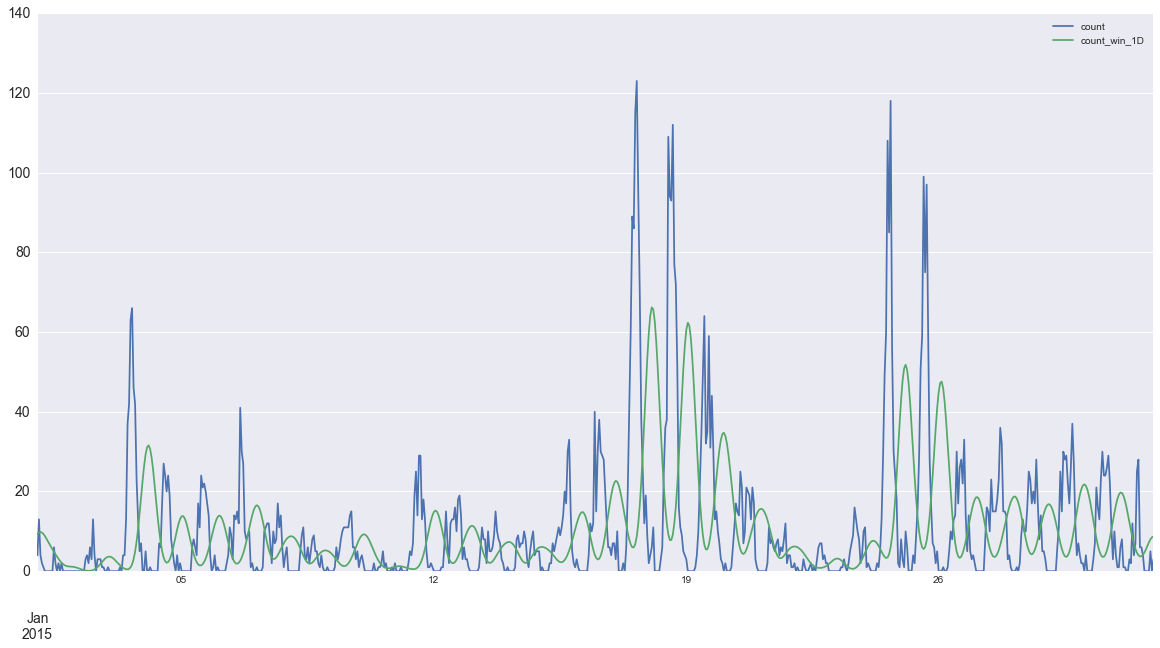

In [20]:
# Lag features

plot_df = train_df['2015-01-01':'2015-01-31']
plot_lines(plot_df[['count', 'count_win_1D']], plt.subplots(1,1,figsize=(20,10)), title='', xlabel='', ylabel='')

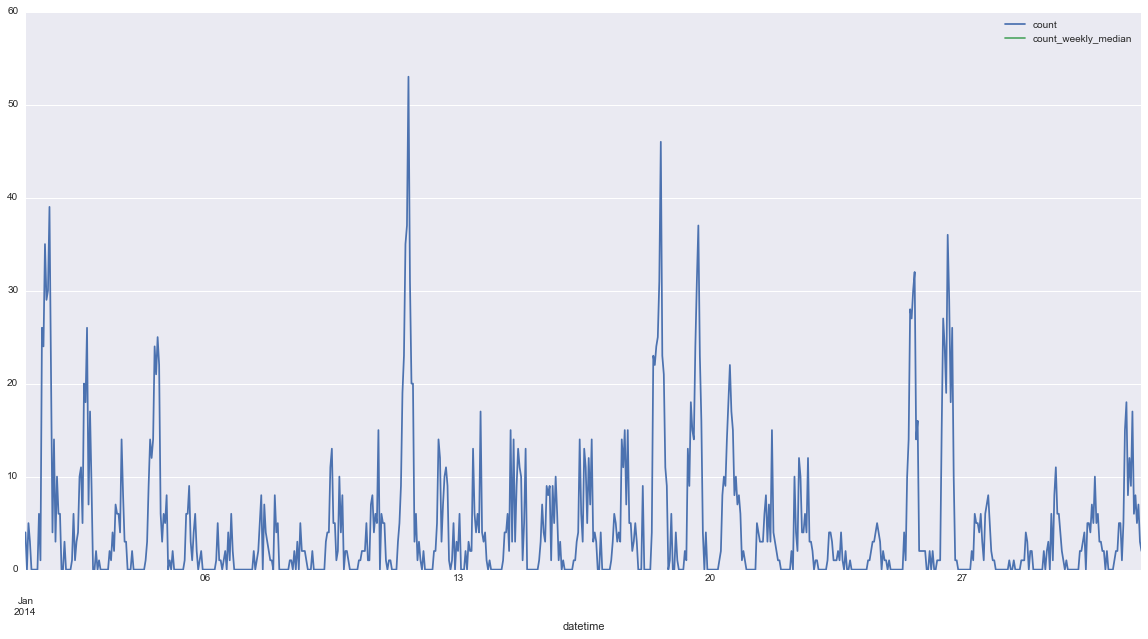

In [21]:
train_df.loc['2014-01-01':'2014-01-31', ('count', 'count_weekly_median')].plot.line(figsize=(20,10))

### Evaluating the model

In [22]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (21168, 187), y_train shape: (21168,)
X_val shape: (5136, 187), y_val shape: (5136,)


Time and Weather Feature Regression RMSE - Train: 14.95, Val: 12.00


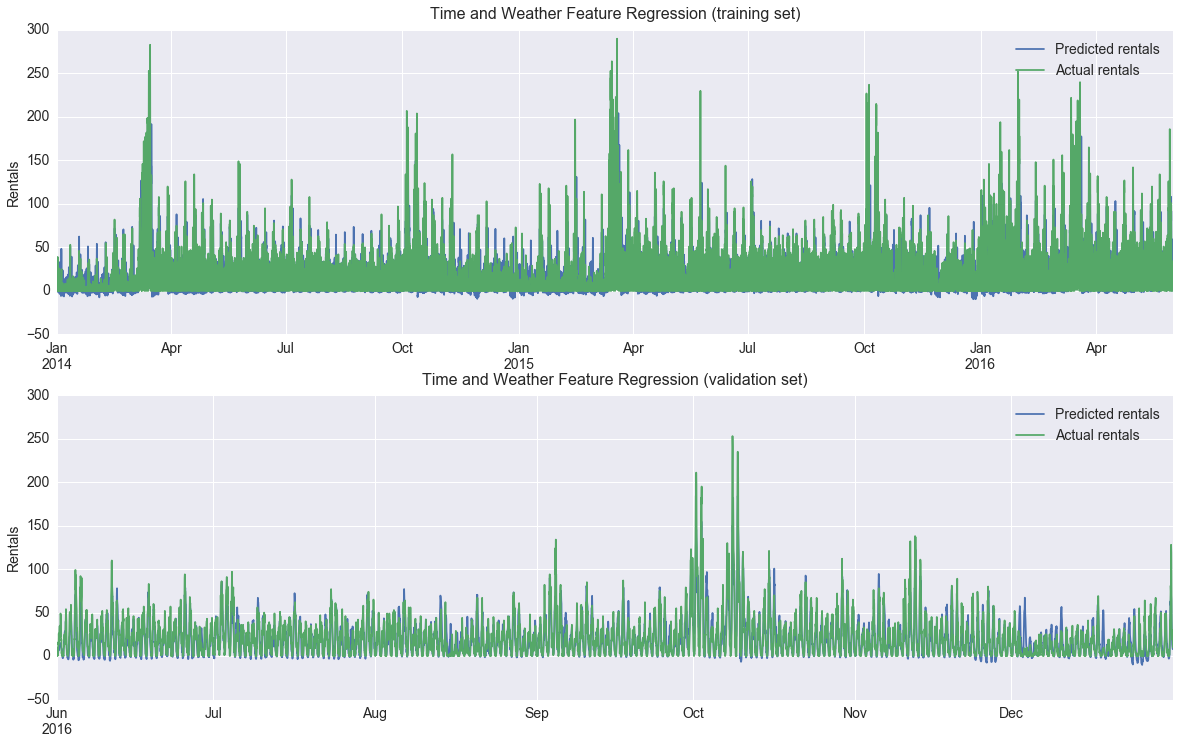

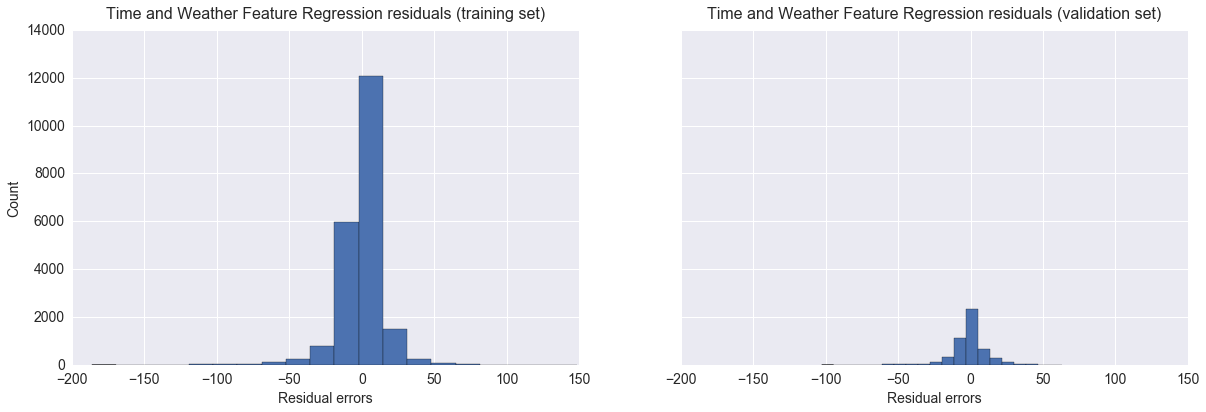

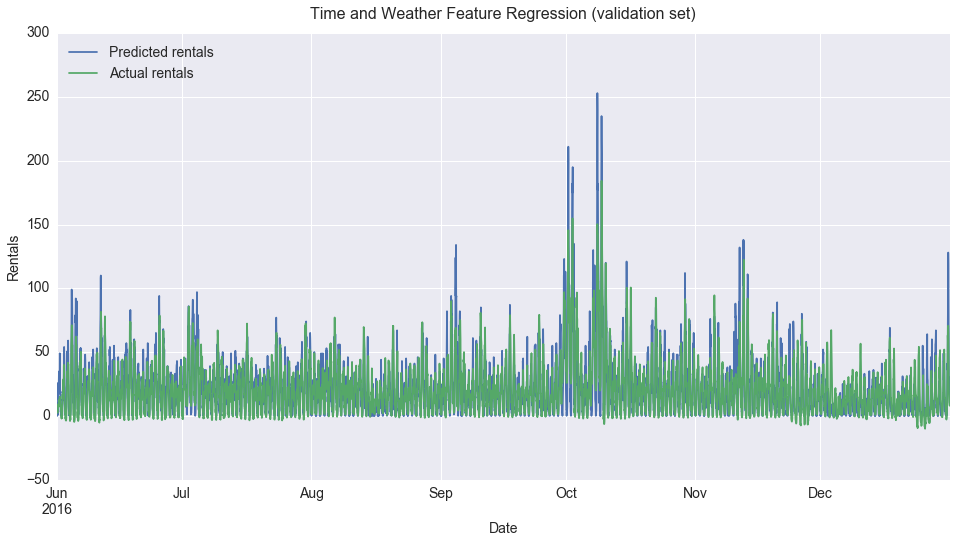

In [23]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# # Store the evaluation results
# if 'linreg_time_weather_feat' not in scores_df.index:
#     scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
#                                               index=['linreg_time_weather_feat']))

print('Time and Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')

In [24]:
# train_weather_df['precipitation'].plot.hist(bins=40, figsize=(20,10))

# Weather-based models

Now we've added in all the time-based features that 

In [25]:
# # Merge the training and validation datasets with the weather dataframe

def merge_daily_weather(df, weather_df):
    '''Merges the dataframes using the date in their indexes
    INPUT: df - Dataframe to be merged with date-based index
           weather_df - Dataframe to be merged with date-based index
    RETURNS: merged dataframe
    '''    

    # Extract the date only from df's index
    df = df.reset_index()
    df['date'] = df['datetime'].dt.date.astype('datetime64')
#     df = df.set_index('datetime')
    
    # Extract the date field to join on
    weather_df = weather_df.reset_index()
    weather_df['date'] = weather_df['date'].astype('datetime64')
    
    # Merge with the weather information using the date
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    merged_df.index = df.index
    merged_df = merged_df.set_index('datetime', drop=True)
    merged_df = merged_df.drop('date', axis=1)
    assert df.shape[0] == merged_df.shape[0], "Error - row mismatch after merge"
    
    return merged_df

GOOD_COLS = ['max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm']


train_weather_df = merge_daily_weather(train_df, weather_df[GOOD_COLS])
val_weather_df = merge_daily_weather(val_df, weather_df[GOOD_COLS])

train_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21168 entries, 2014-01-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 27 columns):
count               21168 non-null int64
day-hour            21168 non-null object
hol_christmas       21168 non-null uint8
hol_mlk             21168 non-null uint8
hol_memorial        21168 non-null uint8
hol_independence    21168 non-null uint8
hol_new_year        21168 non-null uint8
hol_veterans        21168 non-null uint8
hol_labor           21168 non-null uint8
hol_thanksgiving    21168 non-null uint8
hol_columbus        21168 non-null uint8
hol_presidents      21168 non-null uint8
event_sxsw          21168 non-null uint8
event_acl           21168 non-null uint8
count_lag_1D        21168 non-null float64
count_lag_1W        21168 non-null float64
count_win_1D        21168 non-null float64
count_win_1W        21168 non-null float64
count_med_1D        21168 non-null float64
count_med_1W        21168 non-null float64
count_med_1M        211

In [26]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(train_weather_df,
                                    target_col='count', 
                                    ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(val_weather_df,
                                target_col='count', 
                                ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (21168, 193), y_train shape: (21168,)
X_val shape: (5136, 193), y_val shape: (5136,)


Time and Weather Feature Regression RMSE - Train: 14.67, Val: 11.75


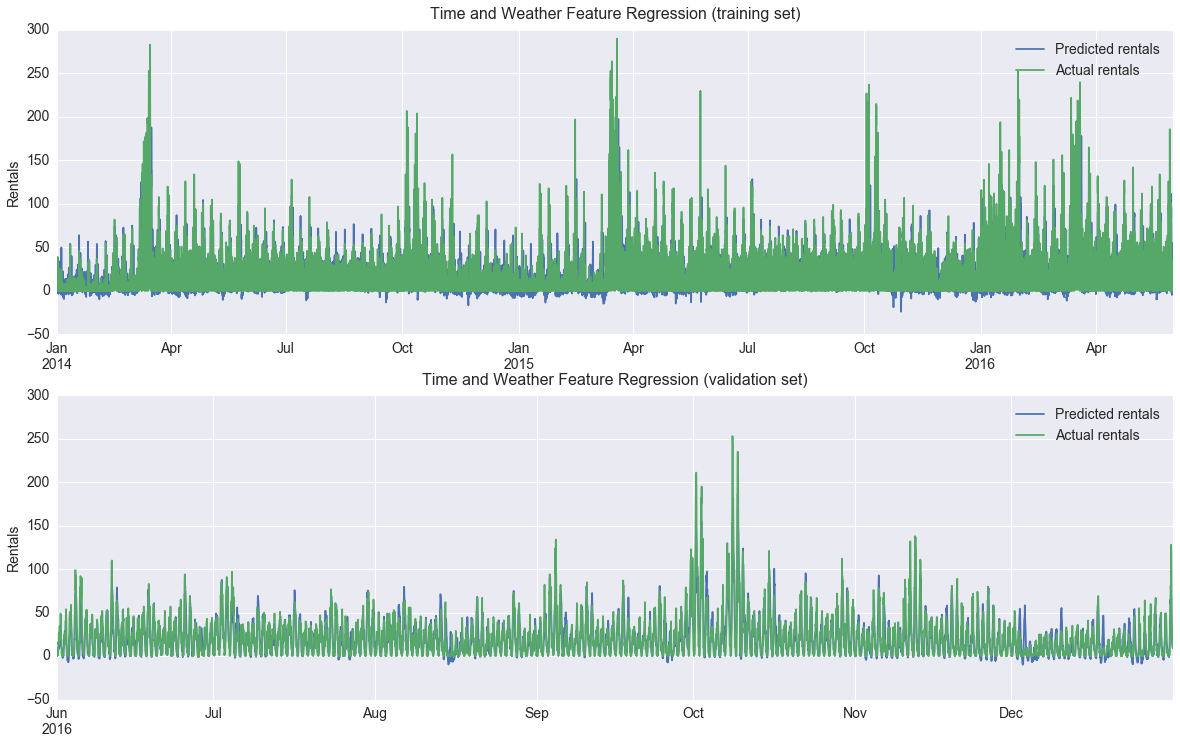

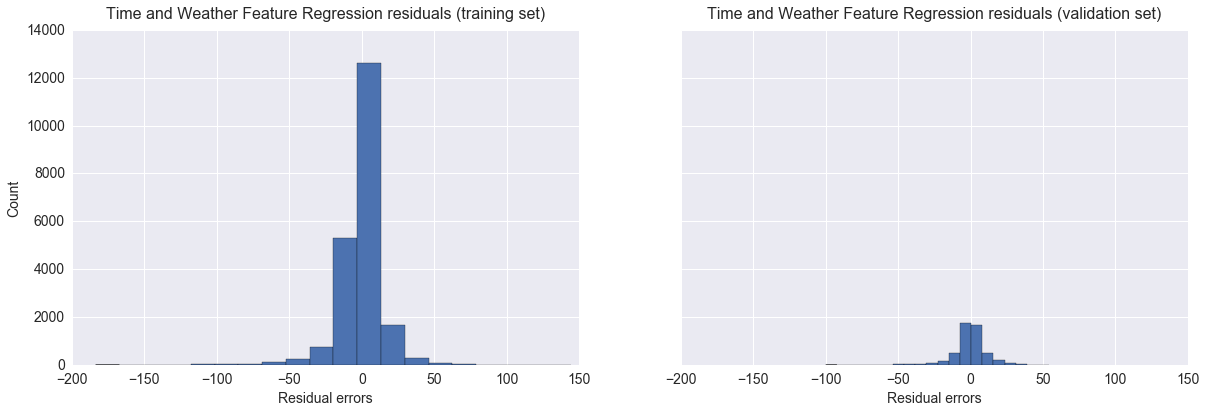

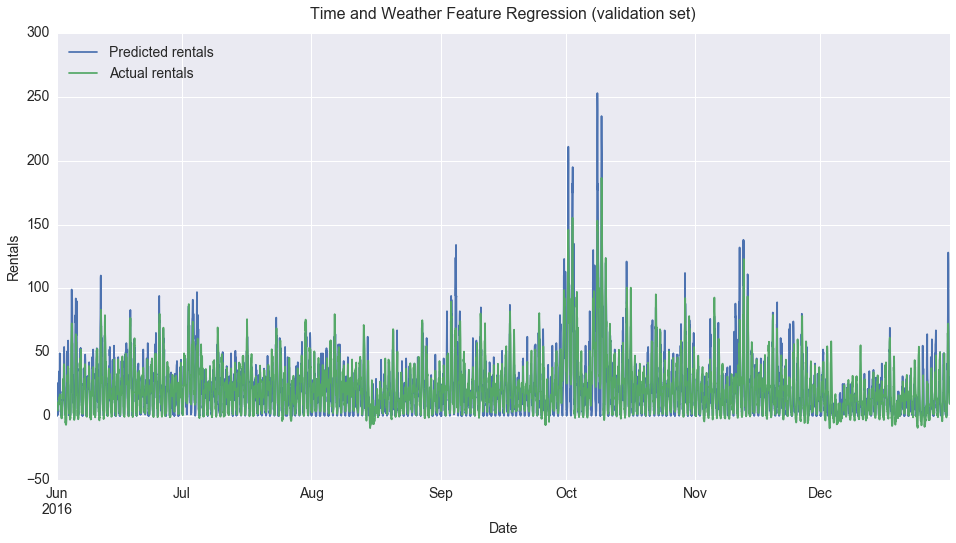

In [27]:
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# # Store the evaluation results
# if 'linreg_time_weather_feat' not in scores_df.index:
#     scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
#                                               index=['linreg_time_weather_feat']))

print('Time and Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')

# Other models?

Time and Weather Feature Regression RMSE - Train: 4.91, Val: 12.53


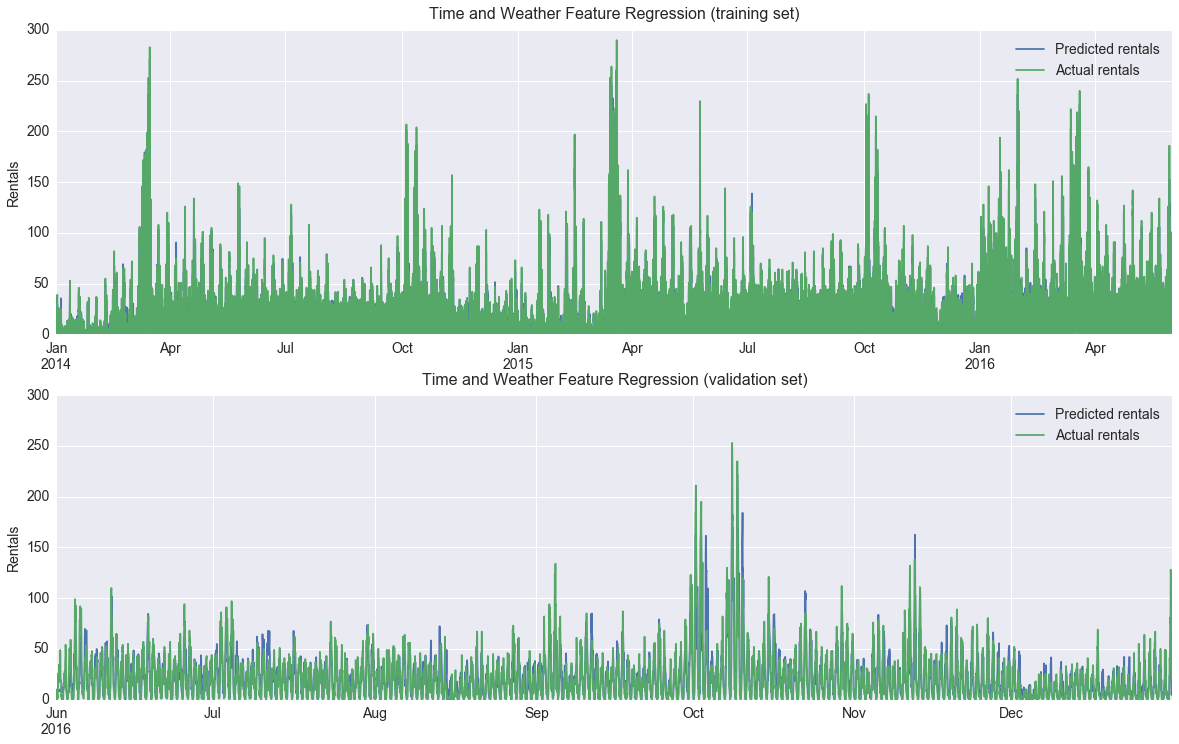

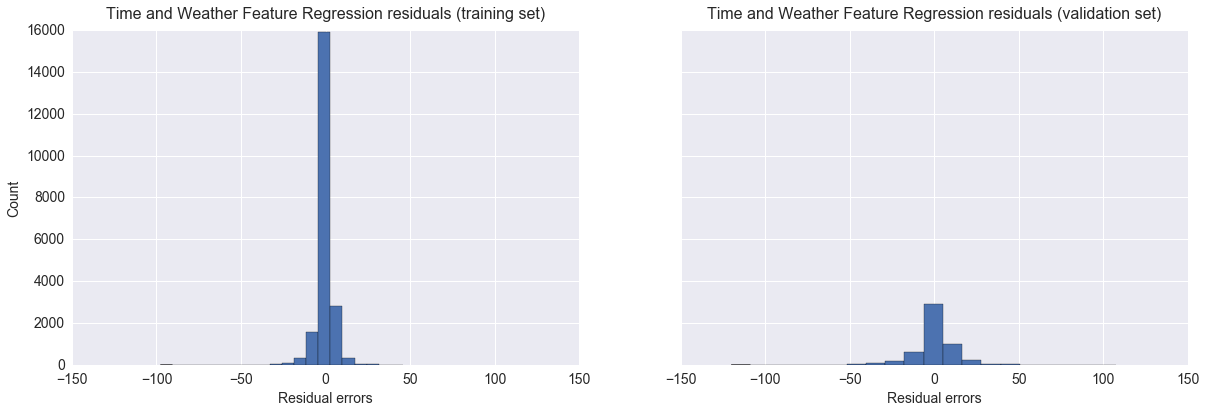

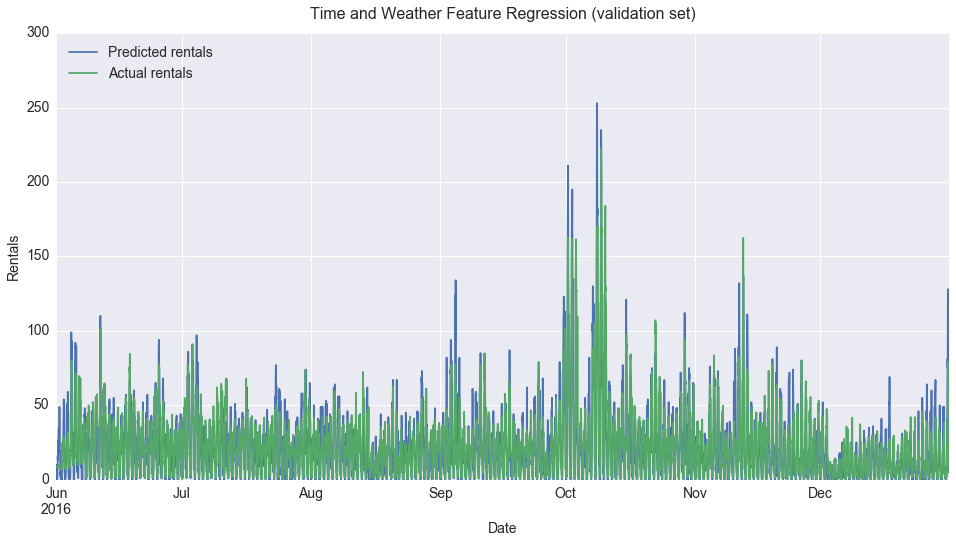

In [28]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=20, max_depth=100)
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# # Store the evaluation results
# if 'linreg_time_weather_feat' not in scores_df.index:
#     scores_df = scores_df.append(pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, 
#                                               index=['linreg_time_weather_feat']))

print('Time and Weather Feature Regression RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))

reg_result_train_df, reg_result_val_df = df_from_results(train_df.index, y_train, y_train_pred,
                                                         val_df.index, y_val, y_val_pred)

plot_results(reg_result_train_df, reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')
plot_val(reg_result_val_df, 'pred', 'true', title='Time and Weather Feature Regression')

In [29]:
import xgboost

ImportError: No module named 'xgboost'

In [ ]:
norm_trip_df.info()